
# 0. Setup Paths and Install Tensorflow using pyspark

In [4]:
import os

In [5]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [6]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [7]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [8]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

In [9]:
pip install spark-tensorflow-distributor

Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


In [5]:
#tensorflow using pyspark
from spark_tensorflow_distributor import MirroredStrategyRunner

# Taken from https://github.com/tensorflow/ecosystem/tree/master/spark/spark-tensorflow-distributor#examples
def train():
    import tensorflow as tf
    import uuid

    BUFFER_SIZE = 10000
    BATCH_SIZE = 64

    def make_datasets():
        (mnist_images, mnist_labels), _ = \
            tf.keras.datasets.mnist.load_data(path=str(uuid.uuid4())+'mnist.npz')

        dataset = tf.data.Dataset.from_tensor_slices((
            tf.cast(mnist_images[..., tf.newaxis] / 255.0, tf.float32),
            tf.cast(mnist_labels, tf.int64))
        )
        dataset = dataset.repeat().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
        return dataset

    def build_and_compile_cnn_model():
        model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(28, 28, 1)),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax'),
        ])
        model.compile(
            loss=tf.keras.losses.sparse_categorical_crossentropy,
            optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
            metrics=['accuracy'],
        )
        return model

    train_datasets = make_datasets()
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
    train_datasets = train_datasets.with_options(options)
    multi_worker_model = build_and_compile_cnn_model()
    multi_worker_model.fit(x=train_datasets, epochs=3, steps_per_epoch=5)

MirroredStrategyRunner(num_slots=8).run(train)

Doing GPU training...


Exception: Your cluster might not have Spark GPU-aware scheduling enabled, please contact your cluster administrator.The conf `spark.task.resource.gpu.amount` was not found in the Spark configuration.

# 1. Download TF Models Pretrained Models from Tensorflow Model Zoo and Install TFOD

In [6]:
# https://www.tensorflow.org/install/source_windows

In [11]:
if os.name=='nt':
    !pip install wget
    import wget

In [12]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

In [13]:
# Install Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e . 

100% [..........................................................................] 1468733 / 1468733        1 file(s) moved.
        1 file(s) copied.
running build
running build_py
copying object_detection\protos\anchor_generator_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\argmax_matcher_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\bipartite_matcher_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\box_coder_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\box_predictor_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\calibration_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\center_net_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\eval_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\faster_rcnn_box_coder_pb2.py -> build\lib\object_detection\protos
copying obj

C:\Users\satya\OneDrive\Desktop\Number plate detection\TFODCourse\anprsys\lib\site-packages\setuptools_scm\integration.py:16: RuntimeWarning: 
ERROR: setuptools==41.2.0 is used in combination with setuptools_scm>=6.x

Your build configuration is incomplete and previously worked by accident!


This happens as setuptools is unable to replace itself when a activated build dependency
requires a more recent setuptools version
(it does not respect "setuptools>X" in setup_requires).


setuptools>=31 is required for setup.cfg metadata support
setuptools>=42 is required for pyproject.toml configuration support

Suggested workarounds if applicable:
 - preinstalling build dependencies like setuptools_scm before running setup.py
 - installing setuptools_scm using the system package manager to ensure consistency
 - migrating from the deprecated setup_requires mechanism to pep517/518
   and using a pyproject.toml to declare build dependencies
   which are reliably pre-installed before running the bu


copying build\lib\object_detection\anchor_generators\multiscale_grid_anchor_generator_test.py -> build\bdist.win-amd64\egg\object_detection\anchor_generators
copying build\lib\object_detection\anchor_generators\__init__.py -> build\bdist.win-amd64\egg\object_detection\anchor_generators
creating build\bdist.win-amd64\egg\object_detection\box_coders
copying build\lib\object_detection\box_coders\faster_rcnn_box_coder.py -> build\bdist.win-amd64\egg\object_detection\box_coders
copying build\lib\object_detection\box_coders\faster_rcnn_box_coder_test.py -> build\bdist.win-amd64\egg\object_detection\box_coders
copying build\lib\object_detection\box_coders\keypoint_box_coder.py -> build\bdist.win-amd64\egg\object_detection\box_coders
copying build\lib\object_detection\box_coders\keypoint_box_coder_test.py -> build\bdist.win-amd64\egg\object_detection\box_coders
copying build\lib\object_detection\box_coders\mean_stddev_box_coder.py -> build\bdist.win-amd64\egg\object_detection\box_coders
copyi

Obtaining file:///C:/Users/satya/OneDrive/Desktop/Number%20plate%20detection/TFODCourse/Tensorflow/models/research/slim
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Attempting uninstall: slim
    Found existing installation: slim 0.1
    Uninstalling slim-0.1:
      Successfully uninstalled slim-0.1
  Running setup.py develop for slim


In [24]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

2021-12-22 14:54:58.836726: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-12-22 14:54:58.836764: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-12-22 14:55:03.074223: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'nvcuda.dll'; dlerror: nvcuda.dll not found
2021-12-22 14:55:03.074251: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-22 14:55:03.078049: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: Satyam
2021-12-22 14:55:03.078094: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: Satyam
Running tests under Python 3.8.0: C:\Users\satya\OneDrive\Desktop\Number plate detection\TFODCourse\anprsys\Scripts\python.e

I1222 14:55:28.423411  6744 efficientnet_model.py:147] round_filter input=192 output=272
I1222 14:55:28.423411  6744 efficientnet_model.py:147] round_filter input=320 output=448
I1222 14:55:28.856569  6744 efficientnet_model.py:147] round_filter input=1280 output=1792
I1222 14:55:28.959124  6744 efficientnet_model.py:457] Building model efficientnet with params ModelConfig(width_coefficient=1.4, depth_coefficient=1.8, resolution=380, dropout_rate=0.4, blocks=(BlockConfig(input_filters=32, output_filters=16, kernel_size=3, num_repeat=1, expand_ratio=1, strides=(1, 1), se_ratio=0.25, id_skip=True, fused_conv=False, conv_type='depthwise'), BlockConfig(input_filters=16, output_filters=24, kernel_size=3, num_repeat=2, expand_ratio=6, strides=(2, 2), se_ratio=0.25, id_skip=True, fused_conv=False, conv_type='depthwise'), BlockConfig(input_filters=24, output_filters=40, kernel_size=5, num_repeat=2, expand_ratio=6, strides=(2, 2), se_ratio=0.25, id_skip=True, fused_conv=False, conv_type='depthw

In [25]:
pip install Pillow

Note: you may need to restart the kernel to use updated packages.


In [26]:
pip install tf-models-official

Note: you may need to restart the kernel to use updated packages.


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\satya\OneDrive\Desktop\Number plate detection\TFODCourse\anprsys\Scripts\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\satya\\AppData\\Local\\Temp\\pip-install-wt2tusvz\\pycocotools_b43fa75c32aa456581eacdfce0703600\\setup.py'"'"'; __file__='"'"'C:\\Users\\satya\\AppData\\Local\\Temp\\pip-install-wt2tusvz\\pycocotools_b43fa75c32aa456581eacdfce0703600\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\satya\AppData\Local\Temp\pip-wheel-6mfd4z_t'
       cwd: C:\Users\satya\AppData\Local\Temp\pip-install-wt2tusvz\pycocotools_b43fa75c32aa456581eacdfce0703600\
  Complete output (14 lines):
  running bdist_wheel
  running build
  runni

  Using cached google_api_python_client-2.33.0-py2.py3-none-any.whl (7.9 MB)
  Using cached kaggle-1.5.12-py3-none-any.whl
  Using cached oauth2client-4.1.3-py2.py3-none-any.whl (98 kB)
  Using cached opencv_python_headless-4.5.4.60-cp38-cp38-win_amd64.whl (35.0 MB)
  Using cached psutil-5.8.0-cp38-cp38-win_amd64.whl (245 kB)
  Using cached py_cpuinfo-8.0.0-py3-none-any.whl
  Using cached pycocotools-2.0.3.tar.gz (106 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for pycocotools
Failed to build pycocotools
    Running setup.py install for pycocotools: started
    Running setup.py install for pycocotools: finished with status 'error'


  copying pycocotools\mask.py -> build\lib.win-amd64-3.8\pycocotools
  copying pycocotools\__init__.py -> build\lib.win-amd64-3.8\pycocotools
  running build_ext
  skipping 'pycocotools\_mask.c' Cython extension (up-to-date)
  building 'pycocotools._mask' extension
  error: Microsoft Visual C++ 14.0 is required. Get it with "Microsoft Visual C++ Build Tools": https://visualstudio.microsoft.com/downloads/
  ----------------------------------------
  ERROR: Failed building wheel for pycocotools
    ERROR: Command errored out with exit status 1:
     command: 'C:\Users\satya\OneDrive\Desktop\Number plate detection\TFODCourse\anprsys\Scripts\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\satya\\AppData\\Local\\Temp\\pip-install-wt2tusvz\\pycocotools_b43fa75c32aa456581eacdfce0703600\\setup.py'"'"'; __file__='"'"'C:\\Users\\satya\\AppData\\Local\\Temp\\pip-install-wt2tusvz\\pycocotools_b43fa75c32aa456581eacdfce0703600\\setup.py'"'"';f = getattr(tok

In [27]:
!pip install scipy

In [28]:
pip install tensorflow.io

Note: you may need to restart the kernel to use updated packages.


In [29]:
!pip install tensorflow --upgrade

In [30]:
!pip uninstall protobuf matplotlib -y
!pip install protobuf matplotlib==3.2

Found existing installation: protobuf 3.19.1
Uninstalling protobuf-3.19.1:
  Successfully uninstalled protobuf-3.19.1
Found existing installation: matplotlib 3.2.0
Uninstalling matplotlib-3.2.0:
  Successfully uninstalled matplotlib-3.2.0


  Using cached protobuf-3.19.1-cp38-cp38-win_amd64.whl (895 kB)
  Using cached matplotlib-3.2.0-cp38-cp38-win_amd64.whl (9.2 MB)

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
easyocr 1.4.1 requires opencv-python-headless, which is not installed.
object-detection 0.1 requires apache-beam, which is not installed.
object-detection 0.1 requires avro-python3, which is not installed.
object-detection 0.1 requires contextlib2, which is not installed.
object-detection 0.1 requires lxml, which is not installed.
object-detection 0.1 requires pycocotools, which is not installed.
tf-models-official 2.7.0 requires google-api-python-client>=1.6.7, which is not installed.
tf-models-official 2.7.0 requires kaggle>=1.3.9, which is not installed.
tf-models-official 2.7.0 requires oauth2client, which is not installed.
tf-models-official 2.7.0 requires opencv-python-headless, which is not installed.
tf-models-official 2.7.0 requires psutil>=5.4.3, which is not installed.
tf-models-official 2.7.0 requires 

In [31]:
import object_detection

In [32]:
!pip list

Package                       Version     Editable project location
----------------------------- ----------- -------------------------------------------------------------------------------------------------
absl-py                       0.12.0
argon2-cffi                   21.1.0
astunparse                    1.6.3
attrs                         21.2.0
backcall                      0.2.0
bleach                        4.1.0
cachetools                    4.2.4
certifi                       2021.10.8
cffi                          1.15.0
charset-normalizer            2.0.7
colorama                      0.4.4
cycler                        0.11.0
Cython                        0.29.24
debugpy                       1.5.1
decorator                     5.1.0
defusedxml                    0.7.1
dill                          0.3.4
dm-tree                       0.1.6
easyocr                       1.4.1
entrypoints                   0.3
flatbuffers                   2.0
fonttools                    

portalocker                   2.3.2
prometheus-client             0.12.0
promise                       2.3
prompt-toolkit                3.0.22
protobuf                      3.19.1
py4j                          0.10.9.2
pyasn1                        0.4.8
pyasn1-modules                0.2.8
pycocotools-windows           2.0.0.2
pycparser                     2.21
Pygments                      2.10.0
pyparsing                     3.0.6
pyrsistent                    0.18.0
pyspark                       3.2.0
python-bidi                   0.4.2
python-dateutil               2.8.2
python-slugify                5.0.2
pytz                          2021.3
PyWavelets                    1.2.0
pywin32                       302
pywinpty                      1.1.6
PyYAML                        6.0
pyzmq                         22.3.0
regex                         2021.11.10
requests                      2.26.0
requests-oauthlib             1.3.0
rsa                           4.7.2
sacrebleu        

In [33]:
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

100% [........................................................................] 20515344 / 20515344        1 file(s) moved.


x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/checkpoint
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.index
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/saved_model.pb
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/variables.data-00000-of-00001
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/variables.index


# 2. Create Label Map

In [14]:
labels = [{'name':'licence', 'id':1}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 3. Create TF records

In [15]:
# OPTIONAL IF RUNNING ON COLAB
ARCHIVE_FILES = os.path.join(paths['IMAGE_PATH'], 'archive.tar.gz')
if os.path.exists(ARCHIVE_FILES):
  !tar -zxvf {ARCHIVE_FILES}

In [16]:
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}

In [17]:
pip install pandas


Note: you may need to restart the kernel to use updated packages.


In [18]:
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 

Successfully created the TFRecord file: Tensorflow\workspace\annotations\train.record
Successfully created the TFRecord file: Tensorflow\workspace\annotations\test.record


# 4. Copy Model Config to Training Folder

In [19]:
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

        1 file(s) copied.


# 5. Update Config For Transfer Learning

In [20]:
pip install protobuf

Note: you may need to restart the kernel to use updated packages.


In [21]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [22]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [23]:
config

{'model': ssd {
   num_classes: 90
   image_resizer {
     fixed_shape_resizer {
       height: 320
       width: 320
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0.0
           stddev: 0.009999999776482582
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.996999979019165
         scale: true
         epsilon: 0.0010000000474974513
       }
     }
     use_depthwise: true
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
       additional_layer_depth: 128
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   matc

In [24]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [26]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [27]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# 6. Train the model

In [14]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [28]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=2000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [29]:
print(command)

python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\my_ssd_mobnet --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --num_train_steps=2000


In [ ]:
!{command}

# 7. Evaluate the Model

In [15]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])

In [16]:
print(command)

python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\my_ssd_mobnet --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --checkpoint_dir=Tensorflow\workspace\models\my_ssd_mobnet


In [17]:
!{command}

2021-11-24 13:14:07.892823: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-11-24 13:14:07.892862: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Traceback (most recent call last):
  File "Tensorflow\models\research\object_detection\model_main_tf2.py", line 32, in <module>
    from object_detection import model_lib_v2
  File "C:\Users\satya\OneDrive\Desktop\Number plate detection\TFODCourse\anprsys\lib\site-packages\object_detection-0.1-py3.8.egg\object_detection\model_lib_v2.py", line 29, in <module>
    from object_detection import eval_util
  File "C:\Users\satya\OneDrive\Desktop\Number plate detection\TFODCourse\anprsys\lib\site-packages\object_detection-0.1-py3.8.egg\object_detection\eval_util.py", line 36, in <module>
    from object_detection.metrics import lvis_evaluation
  File "C:\Users\s

# 8. Load Train Model From Checkpoint

In [12]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [13]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [14]:
# Prevent GPU complete consumption
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try: 
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RunTimeError as e:
        print(e)

In [15]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-3')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 9. Detect from an Image

In [16]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [17]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [18]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [40]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', 'Cars426.png')

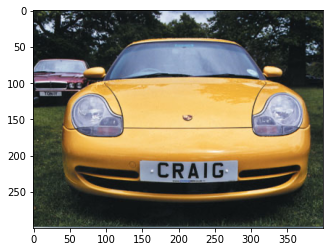

In [41]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

# Apply OCR Detection

In [23]:
!python -m pip install easyocr 

  Using cached opencv_python_headless-4.5.4.60-cp38-cp38-win_amd64.whl (35.0 MB)


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\satya\\OneDrive\\Desktop\\Number plate detection\\TFODCourse\\anprsys\\Lib\\site-packages\\cv2\\cv2.cp38-win_amd64.pyd'
Check the permissions.



In [22]:
!pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [42]:
import easyocr


In [43]:
detection_threshold = 0.7

In [44]:
image = image_np_with_detections
scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
boxes = detections['detection_boxes'][:len(scores)]
classes = detections['detection_classes'][:len(scores)]

In [45]:
width = image.shape[1]
height = image.shape[0]

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[0.6834588  0.33996364 0.8085823  0.7078415 ]
[205.03764153 135.9854579  242.57469177 283.13660622]
[([[32, 2], [134, 2], [134, 32], [32, 32]], 'CRAIG', 0.9960382031318875)]


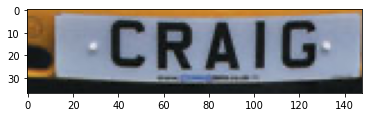

In [46]:
# Apply ROI filtering and OCR
for idx, box in enumerate(boxes):
    print(box)
    roi = box*[height, width, height, width]
    print(roi)
    region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
    reader = easyocr.Reader(['en'])
    ocr_result = reader.readtext(region)
    print(ocr_result)
    plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))

In [47]:
for result in ocr_result:
    print(np.sum(np.subtract(result[0][2],result[0][1])))
    print(result[1])

30
CRAIG


# OCR Filtering

In [48]:
region_threshold = 0.05

In [49]:
def filter_text(region, ocr_result, region_threshold):
    rectangle_size = region.shape[0]*region.shape[1]
    
    plate = [] 
    for result in ocr_result:
        length = np.sum(np.subtract(result[0][1], result[0][0]))
        height = np.sum(np.subtract(result[0][2], result[0][1]))
        
        if length*height / rectangle_size > region_threshold:
            plate.append(result[1])
    return plate

In [50]:
filter_text(region, ocr_result, region_threshold)

['CRAIG']

# Bring it Together

In [51]:
region_threshold = 0.6

In [52]:
def ocr_it(image, detections, detection_threshold, region_threshold):
    
    # Scores, boxes and classes above threhold
    scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
    boxes = detections['detection_boxes'][:len(scores)]
    classes = detections['detection_classes'][:len(scores)]
    
    # Full image dimensions
    width = image.shape[1]
    height = image.shape[0]
    
    # Apply ROI filtering and OCR
    for idx, box in enumerate(boxes):
        roi = box*[height, width, height, width]
        region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
        reader = easyocr.Reader(['en'])
        ocr_result = reader.readtext(region)
        
        text = filter_text(region, ocr_result, region_threshold)
        
        plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
        plt.show()
        print(text)
        return text, region

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


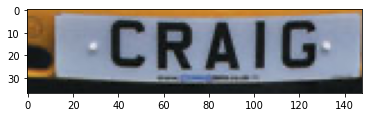

[]


In [59]:
text, region = ocr_it(image_np_with_detections, detections, detection_threshold, region_threshold)

# Save Results

In [54]:
import csv
import uuid

In [55]:
'{}.jpg'.format(uuid.uuid1())

'ce4d59ba-627c-11ec-a3e2-6018954afc7a.jpg'

In [56]:
def save_results(text, region, csv_filename, folder_path):
    img_name = '{}.jpg'.format(uuid.uuid1())
    
    cv2.imwrite(os.path.join(folder_path, img_name), region)
    
    with open(csv_filename, mode='a', newline='') as f:
        csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerow([img_name, text])

In [57]:
region

array([[[ 47, 122, 190],
        [ 44, 122, 188],
        [ 44, 122, 188],
        ...,
        [ 56, 130, 202],
        [ 51, 127, 203],
        [ 47, 127, 204]],

       [[ 42, 116, 180],
        [ 42, 116, 180],
        [ 42, 116, 180],
        ...,
        [108, 142, 172],
        [ 95, 138, 179],
        [ 72, 129, 184]],

       [[ 39, 113, 172],
        [ 39, 111, 175],
        [ 38, 110, 174],
        ...,
        [177, 178, 174],
        [148, 163, 172],
        [101, 139, 171]],

       ...,

       [[ 12,  21,  24],
        [ 26,  24,  14],
        [ 25,  24,  14],
        ...,
        [ 29,  21,  22],
        [ 29,  24,  23],
        [ 28,  25,  20]],

       [[ 24,  23,  19],
        [ 23,  22,  18],
        [ 23,  22,  18],
        ...,
        [ 26,  25,  21],
        [ 25,  24,  20],
        [ 23,  22,  18]],

       [[ 23,  22,  18],
        [ 23,  22,  18],
        [ 23,  22,  18],
        ...,
        [ 23,  22,  18],
        [ 22,  21,  17],
        [ 22,  21,  17]]

In [58]:
save_results(text, region, 'detection_results.csv', 'Detection_Images')

# 10. Real Time Detections from your Webcam

In [37]:
!pip uninstall opencv-python-headless -y

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


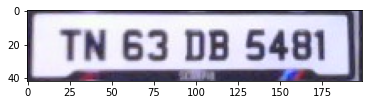

['Tn 63 DB 5481']


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


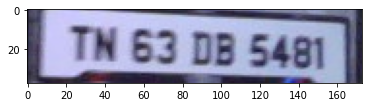

[]


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


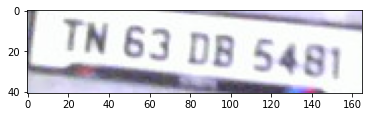

['TN 63 DB 5481']


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


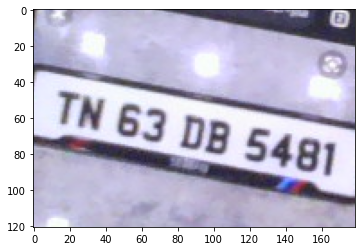

[]


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


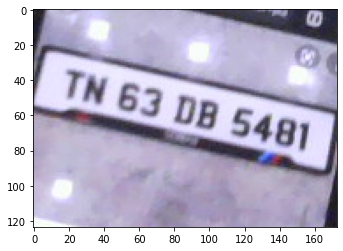

[]


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


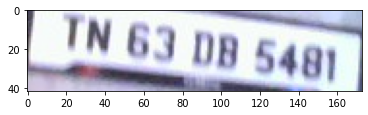

['In 62 DH 5401']


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


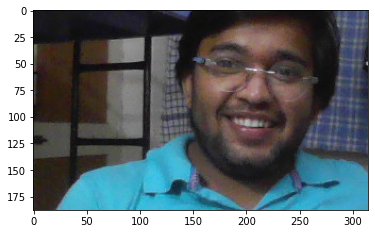

[]


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


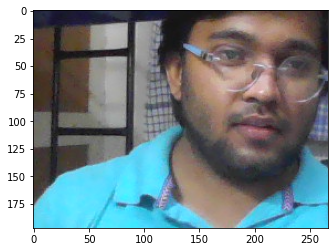

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[]


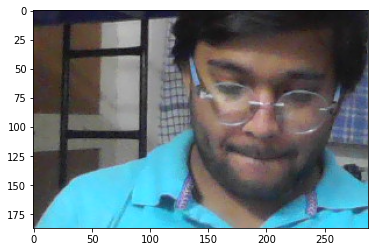

[]


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


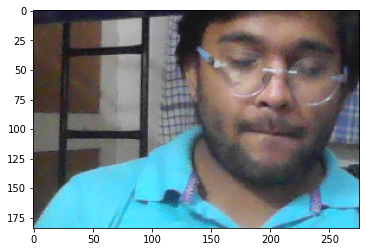

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[]


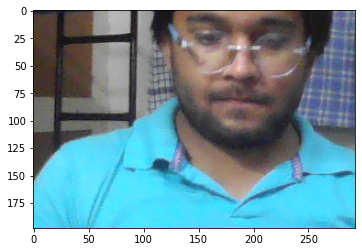

[]


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


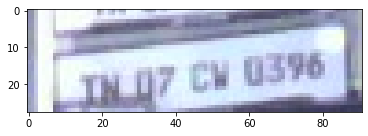

[]


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


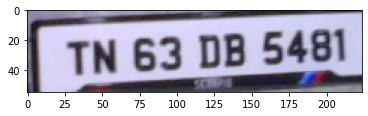

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


['Tn 63 DB 5481']


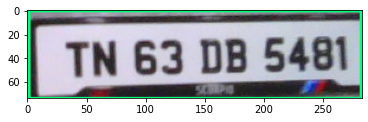

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


['TN 63 DB 5481']


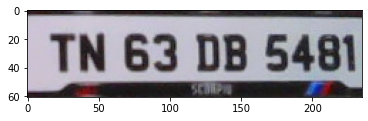

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


['TN 63 DB 5481']


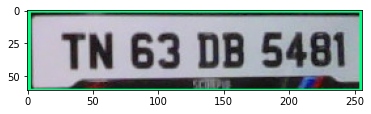

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


['TN 63 DB 5481']


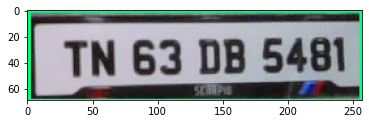

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[]


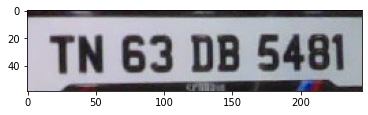

['TN 63 DB 5481']


In [61]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)
    
    try: 
        text, region = ocr_it(image_np_with_detections, detections, detection_threshold, region_threshold)
        save_results(text, region, 'realtimeresults.csv', 'Detection_Images')
    except:
        pass

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break